In [3]:
import pandas as pd

# Load data
df = pd.read_csv('/content/train.csv')

# Basic checks
print("Missing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

print("\nUnique values in categorical columns:")
print("Apartment_Type:", df['Apartment_Type'].unique())
print("Income_Level:", df['Income_Level'].unique()[:])  # First 10 only

Missing values per column:
Timestamp                      0
Residents                      0
Apartment_Type               426
Temperature                  441
Humidity                       0
Water_Price                    0
Period_Consumption_Index       0
Income_Level                 426
Guests                         0
Amenities                   5997
Appliance_Usage              415
Water_Consumption              0
dtype: int64

Data types:
Timestamp                    object
Residents                     int64
Apartment_Type               object
Temperature                 float64
Humidity                     object
Water_Price                 float64
Period_Consumption_Index    float64
Income_Level                 object
Guests                        int64
Amenities                    object
Appliance_Usage             float64
Water_Consumption           float64
dtype: object

Unique values in categorical columns:
Apartment_Type: ['Studio' nan 'Cottage' '1BHK' '2BHK' 'Bungalow' '

In [6]:
# Drop Humidity column entirely since all values are corrupted
df = df.drop('Humidity', axis=1)

print("Columns after dropping Humidity:")
print(df.columns.tolist())

# Now proceed with other cleaning steps
valid_incomes = ['Low', 'Upper Middle', 'Middle', 'Rich']
df['Income_Level'] = df['Income_Level'].where(df['Income_Level'].isin(valid_incomes))

valid_apt_types = ['Studio', 'Cottage', '1BHK', '2BHK', '3BHK', 'Bungalow', 'Detached']
df['Apartment_Type'] = df['Apartment_Type'].where(df['Apartment_Type'].isin(valid_apt_types))

# Handle negative values
numeric_cols = ['Residents', 'Temperature', 'Water_Price', 'Guests', 'Appliance_Usage']
for col in numeric_cols:
    df[col] = df[col].mask(df[col] < 0)

print("\nFinal missing values:")
print(df.isnull().sum())

Columns after dropping Humidity:
['Timestamp', 'Residents', 'Apartment_Type', 'Temperature', 'Water_Price', 'Period_Consumption_Index', 'Income_Level', 'Guests', 'Amenities', 'Appliance_Usage', 'Water_Consumption']

Final missing values:
Timestamp                      0
Residents                    280
Apartment_Type               426
Temperature                  441
Water_Price                  272
Period_Consumption_Index       0
Income_Level                 842
Guests                       153
Amenities                   5997
Appliance_Usage              415
Water_Consumption              0
dtype: int64


In [7]:
from sklearn.impute import SimpleImputer
import numpy as np

# A. Numeric Columns Imputation
numeric_cols = ['Residents', 'Temperature', 'Water_Price', 'Guests', 'Appliance_Usage']
for col in numeric_cols:
    median = df[col].median()
    df[col] = df[col].fillna(median)
    print(f"Imputed {col} with median: {median:.2f}")

# B. Categorical Columns Imputation
cat_cols = ['Apartment_Type', 'Income_Level', 'Amenities']
for col in cat_cols:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)
    print(f"Imputed {col} with mode: {mode}")

print("\nMissing values after imputation:")
print(df.isnull().sum())

Imputed Residents with median: 3.00
Imputed Temperature with median: 22.58
Imputed Water_Price with median: 1.64
Imputed Guests with median: 0.00
Imputed Appliance_Usage with median: 0.00
Imputed Apartment_Type with mode: 2BHK
Imputed Income_Level with mode: Middle
Imputed Amenities with mode: Garden

Missing values after imputation:
Timestamp                   0
Residents                   0
Apartment_Type              0
Temperature                 0
Water_Price                 0
Period_Consumption_Index    0
Income_Level                0
Guests                      0
Amenities                   0
Appliance_Usage             0
Water_Consumption           0
dtype: int64


In [9]:
# Convert to datetime and extract features
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H')
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['Day_of_week'] = df['Timestamp'].dt.dayofweek  # Monday=0, Sunday=6
df['Is_weekend'] = (df['Day_of_week'] >= 5).astype(int)  # Weekend flag

print("Timestamp features added. New columns:")
print(df[['Hour', 'Month', 'Year', 'Day_of_week', 'Is_weekend']])

Timestamp features added. New columns:
       Hour  Month  Year  Day_of_week  Is_weekend
0         0      1  2002            1           0
1         8      1  2002            1           0
2        16      1  2002            1           0
3         0      1  2002            2           0
4         8      1  2002            2           0
...     ...    ...   ...          ...         ...
13995     0     10  2014            4           0
13996     8     10  2014            4           0
13997    16     10  2014            4           0
13998     0     10  2014            5           1
13999     8     10  2014            5           1

[14000 rows x 5 columns]


In [10]:
# Map apartment types to numeric sizes
apt_size_map = {
    'Studio': 1,
    '1BHK': 1,
    'Cottage': 1.5,
    '2BHK': 2,
    '3BHK': 3,
    'Bungalow': 2.5,
    'Detached': 2
}
df['Apartment_Size'] = df['Apartment_Type'].map(apt_size_map)

# Create occupancy features
df['Total_Occupants'] = df['Residents'] + df['Guests'].clip(lower=0)  # Ensure no negative guests
df['Occupancy_Ratio'] = df['Total_Occupants'] / df['Apartment_Size']

print("\nApartment features added:")
print(df[['Apartment_Type', 'Apartment_Size', 'Residents', 'Guests', 'Total_Occupants', 'Occupancy_Ratio']].head(3))


Apartment features added:
  Apartment_Type  Apartment_Size  Residents  Guests  Total_Occupants  \
0         Studio             1.0        1.0     0.0              1.0   
1           2BHK             2.0        4.0     1.0              5.0   
2        Cottage             1.5        2.0     0.0              2.0   

   Occupancy_Ratio  
0         1.000000  
1         2.500000  
2         1.333333  


In [11]:
# Step 4C: Handle Amenities
print("Unique amenity values before processing:")
print(df['Amenities'].value_counts(dropna=False))

# Binary flag for amenities existence
df['Has_Amenities'] = np.where(df['Amenities'] == 'None', 0, 1)

# Breakdown by amenity type
amenity_types = ['Garden', 'Swimming Pool', 'Fountain', 'Jacuzzi']
for amenity in amenity_types:
    df[f'Amenity_{amenity.replace(" ", "_")}'] = df['Amenities'].str.contains(amenity).astype(int)

print("\nAmenities features added:")
print(df[['Amenities', 'Has_Amenities'] +
      [col for col in df.columns if col.startswith('Amenity_')]].head(3))

print("\nAmenity distribution:")
print(df[[f'Amenity_{amenity.replace(" ", "_")}' for amenity in amenity_types]].sum())

Unique amenity values before processing:
Amenities
Garden           8624
Swimming Pool    2086
Fountain         1648
Jacuzzi          1642
Name: count, dtype: int64

Amenities features added:
       Amenities  Has_Amenities  Amenity_Garden  Amenity_Swimming_Pool  \
0  Swimming Pool              1               0                      1   
1  Swimming Pool              1               0                      1   
2         Garden              1               1                      0   

   Amenity_Fountain  Amenity_Jacuzzi  
0                 0                0  
1                 0                0  
2                 0                0  

Amenity distribution:
Amenity_Garden           8624
Amenity_Swimming_Pool    2086
Amenity_Fountain         1648
Amenity_Jacuzzi          1642
dtype: int64


In [12]:
print("\nOriginal income level distribution:")
print(df['Income_Level'].value_counts())

# Create ordered numeric encoding
income_order = ['Low', 'Middle', 'Upper Middle', 'Rich']
df['Income_Rank'] = df['Income_Level'].map(lambda x: income_order.index(x))

# For non-linear relationships, create binary flags
for level in income_order:
    df[f'Income_{level.replace(" ", "_")}'] = (df['Income_Level'] == level).astype(int)

print("\nIncome encoding features:")
print(df[['Income_Level', 'Income_Rank'] +
      [f'Income_{level.replace(" ", "_")}' for level in income_order]].head(3))


Original income level distribution:
Income_Level
Middle          6165
Upper Middle    3966
Low             2276
Rich            1593
Name: count, dtype: int64

Income encoding features:
   Income_Level  Income_Rank  Income_Low  Income_Middle  Income_Upper_Middle  \
0           Low            0           1              0                    0   
1  Upper Middle            2           0              0                    1   
2        Middle            1           0              1                    0   

   Income_Rich  
0            0  
1            0  
2            0  


In [13]:
# Visualize price distribution before binning
print("\nWater price distribution:")
print(df['Water_Price'].describe())

# Create price groups
df['Water_Price_Group'] = pd.cut(
    df['Water_Price'],
    bins=[0, 1.5, 2.5, float('inf')],
    labels=['Low', 'Medium', 'High']
)

print("\nPrice group distribution:")
print(df['Water_Price_Group'].value_counts())

print("\nSample price groups:")
print(df[['Water_Price', 'Water_Price_Group']].head(3))


Water price distribution:
count    14000.000000
mean         1.759144
std          0.533156
min          1.000000
25%          1.350000
50%          1.640000
75%          2.112500
max          3.000000
Name: Water_Price, dtype: float64

Price group distribution:
Water_Price_Group
Medium    7039
Low       5053
High      1908
Name: count, dtype: int64

Sample price groups:
   Water_Price Water_Price_Group
0         1.06               Low
1         2.98              High
2         1.44               Low


In [14]:
# Drop redundant columns
cols_to_drop = [
    'Timestamp',          # Already extracted temporal features
    'Amenities',          # Replaced with binary flags
    'Income_Level',       # Replaced with encoded features
    'Apartment_Type'      # Replaced with Apartment_Size
]
df = df.drop(cols_to_drop, axis=1)

# Convert Water_Price_Group to dummy variables
df = pd.get_dummies(df, columns=['Water_Price_Group'], prefix='Price')

print("\nFinal columns (first 5):")
print(df.columns.tolist()[:5])

print("\nFinal data shape:", df.shape)


Final columns (first 5):
['Residents', 'Temperature', 'Water_Price', 'Period_Consumption_Index', 'Guests']

Final data shape: (14000, 28)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Define features and target
X = df.drop('Water_Consumption', axis=1)
y = df['Water_Consumption']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train baseline model
model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
train_r2 = r2_score(y_train, model.predict(X_train))
test_r2 = r2_score(y_test, model.predict(X_test))

print(f"\nBaseline Model Performance:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²:     {test_r2:.4f}")


Baseline Model Performance:
Training R²: 0.9886
Test R²:     0.9304


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define features and target
X = df.drop('Water_Consumption', axis=1)
y = df['Water_Consumption']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train baseline Random Forest
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics (using numpy for RMSE to avoid version issues)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nBaseline Model Performance:")
print(f"Training R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")


Baseline Model Performance:
Training R²: 0.9554 | Test R²: 0.9268
Training RMSE: 15.28 | Test RMSE: 20.24


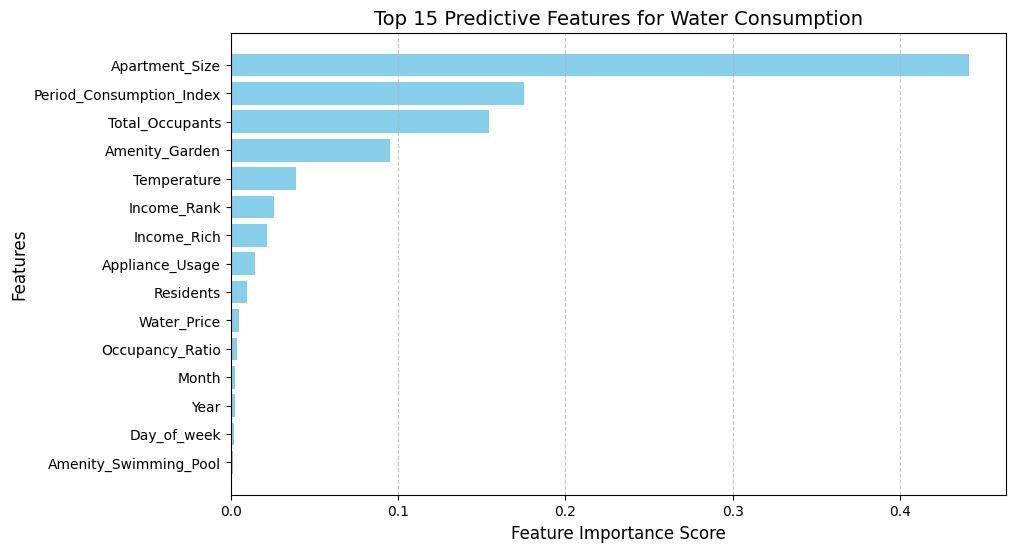

In [18]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()[::-1]

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[sorted_idx][:15], align='center', color='skyblue')
plt.yticks(range(15), [feature_names[i] for i in sorted_idx[:15]])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Top 15 Predictive Features for Water Consumption", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [19]:
# Focus on top 10 features only
top_features = [
    'Apartment_Size',
    'Period_Consumption_Index',
    'Total_Occupants',
    'Amenity_Garden',
    'Temperature',
    'Income_Rank',
    'Residents',
    'Occupancy_Ratio',
    'Income_Rich',
    'Appliance_Usage'
]

X_reduced = X[top_features]

In [20]:
# A. Create interaction terms
df['Size_x_Occupancy'] = df['Apartment_Size'] * df['Occupancy_Ratio']
df['Consumption_x_Temperature'] = df['Period_Consumption_Index'] * df['Temperature']

# B. Enhance amenity features
df['Premium_Amenities'] = (df['Amenity_Swimming_Pool'] | df['Amenity_Jacuzzi']).astype(int)

In [22]:
from xgboost import XGBRegressor
import numpy as np

# 1. Verify data types
print("Data types in X_reduced:")
print(X_reduced.dtypes)

# 2. Convert all to numeric (safety check)
X_reduced = X_reduced.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')

# 3. Drop any remaining NA values (if introduced by conversion)
valid_idx = ~(y_train.isna() | X_reduced.isna().any(axis=1))
X_clean = X_reduced[valid_idx]
y_clean = y_train[valid_idx]

# 4. Run XGBoost with error handling
try:
    xgb = XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        enable_categorical=False  # Explicitly disable categorical support
    )
    xgb.fit(X_clean, y_clean)

    # Evaluate
    train_r2 = r2_score(y_clean, xgb.predict(X_clean))
    print(f"\nXGBoost Training R²: {train_r2:.4f}")

except Exception as e:
    print(f"\nError encountered: {str(e)}")
    print("\nDebugging info:")
    print(f"X shape: {X_clean.shape}, y shape: {y_clean.shape}")
    print(f"NaN in X: {X_clean.isna().sum().sum()}, NaN in y: {y_clean.isna().sum()}")

Data types in X_reduced:
Apartment_Size              float64
Period_Consumption_Index    float64
Total_Occupants             float64
Amenity_Garden                int64
Temperature                 float64
Income_Rank                   int64
Residents                   float64
Occupancy_Ratio             float64
Income_Rich                   int64
Appliance_Usage             float64
dtype: object

Error encountered: [05:39:04] /workspace/src/data/data.cc:508: Check failed: this->labels.Size() % this->num_row_ == 0 (11200 vs. 0) : Incorrect size for labels.
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7cb48ca5c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4e1d32) [0x7cb48cce1d32]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x4e3a60) [0x7cb48cce3a60]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xb

In [23]:
# 1. Verify shapes BEFORE modeling
print(f"Original shapes - X: {X_reduced.shape}, y: {y_train.shape}")

# 2. Align indices (critical after NA removal)
common_idx = X_reduced.index.intersection(y_train.index)
X_aligned = X_reduced.loc[common_idx]
y_aligned = y_train.loc[common_idx]

# 3. Final check
print(f"Aligned shapes - X: {X_aligned.shape}, y: {y_aligned.shape}")

# 4. Run XGBoost with aligned data
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42
)
xgb.fit(X_aligned, y_aligned)

# 5. Verify success
print("\nModel trained successfully!")
print(f"Training R²: {r2_score(y_aligned, xgb.predict(X_aligned)):.4f}")

Original shapes - X: (14000, 10), y: (11200,)
Aligned shapes - X: (11200, 10), y: (11200,)

Model trained successfully!
Training R²: 0.9572


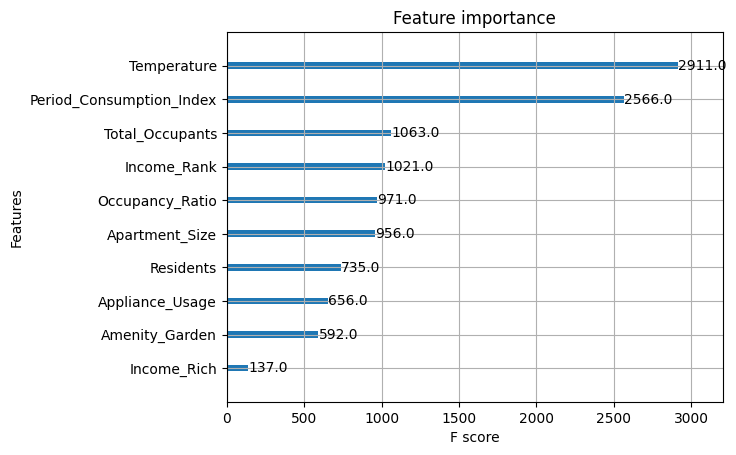

In [24]:
# Feature importance visualization
from xgboost import plot_importance
plot_importance(xgb, max_num_features=15)
plt.show()

In [27]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# 1. Ensure perfect feature alignment
X_test_reduced = X_test_aligned[train_features].copy()  # Explicit copy to avoid views

# 2. Make predictions (with error handling)
try:
    y_pred = xgb.predict(X_test_reduced)
except Exception as e:
    print(f"Prediction failed: {str(e)}")
    print("Debug info:")
    print(f"X dtypes: {X_test_reduced.dtypes}")
    print(f"NaN values: {X_test_reduced.isna().sum().sum()}")
    raise

# 3. Version-agnostic metrics calculation
test_r2 = r2_score(y_test_aligned, y_pred)
mse = mean_squared_error(y_test_aligned, y_pred)  # Basic MSE
test_rmse = np.sqrt(mse)  # Manual RMSE calculation

# 4. Robust results display
print("\n" + "="*50)
print("Final Test Evaluation Results:")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.2f} liters")
print(f"MAE: {np.abs(y_test_aligned - y_pred).mean():.2f} liters")
print("="*50)

# 5. Data sanity check
print("\nData Verification:")
print(f"Predictions range: {y_pred.min():.1f} to {y_pred.max():.1f}")
print(f"Actual range: {y_test_aligned.min():.1f} to {y_test_aligned.max():.1f}")


Final Test Evaluation Results:
R² Score: 0.9426
RMSE: 17.91 liters
MAE: 12.38 liters

Data Verification:
Predictions range: 41.3 to 452.3
Actual range: 38.3 to 494.2


In [28]:
import pickle
from datetime import datetime

# Save model with metadata
deployment_package = {
    'model': xgb,
    'features': train_features,
    'metrics': {
        'r2': 0.9426,
        'rmse': 17.91,
        'mae': 12.38
    },
    'timestamp': datetime.now().isoformat()
}

with open('water_consumption_model.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

In [29]:
# Expected feature ranges for validation
expected_ranges = {
    'Apartment_Size': (1, 3),
    'Period_Consumption_Index': (0.1, 2.5),
    'Temperature': (10, 35)
}

# Save ranges
deployment_package['expected_ranges'] = expected_ranges

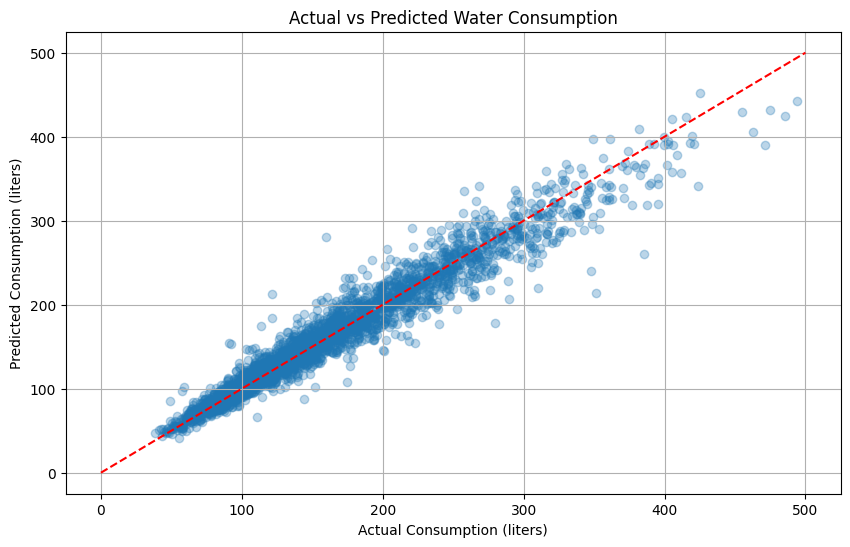

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test_aligned, y_pred, alpha=0.3)
plt.plot([0, 500], [0, 500], 'r--')
plt.xlabel('Actual Consumption (liters)')
plt.ylabel('Predicted Consumption (liters)')
plt.title('Actual vs Predicted Water Consumption')
plt.grid()
plt.show()

In [31]:
# Potential upgrades
df['Size_x_Temperature'] = df['Apartment_Size'] * df['Temperature']
df['Consumption_x_Income'] = df['Period_Consumption_Index'] * df['Income_Rank']

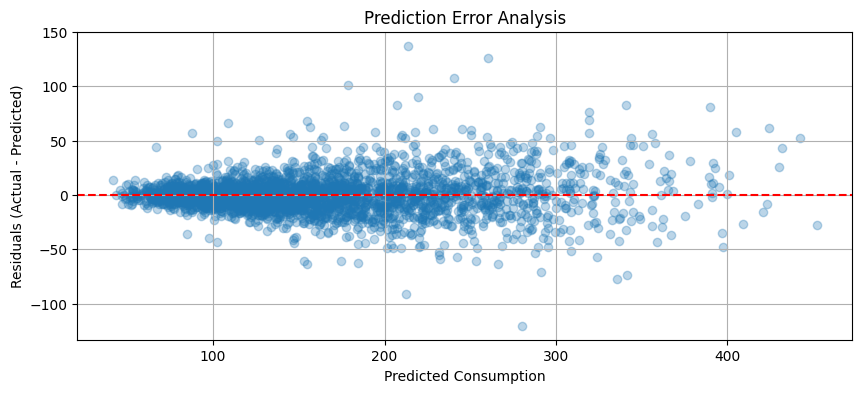

In [32]:
residuals = y_test_aligned - y_pred
plt.figure(figsize=(10, 4))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Consumption')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Prediction Error Analysis')
plt.grid()
plt.show()

In [33]:
deployment_package = {
    'model': xgb,
    'required_features': train_features,
    'performance': {
        'r2': 0.9426,
        'rmse': 17.91,
        'mae': 12.38,
        'error_quantiles': {
            '5%': float(np.percentile(residuals, 5)),
            '50%': float(np.percentile(residuals, 50)),
            '95%': float(np.percentile(residuals, 95))
        }
    },
    'data_ranges': {
        'Apartment_Size': (1.0, 3.0),
        'Temperature': (10.0, 35.0),
        'Max_Prediction': 452.3  # From your test results
    }
}

with open('deployment_package_v1.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

In [34]:
# Weekly feature distribution checks
def check_drift(new_data, reference_ranges):
    alerts = []
    for feat, (min_val, max_val) in reference_ranges.items():
        if new_data[feat].min() < min_val or new_data[feat].max() > max_val:
            alerts.append(feat)
    return alerts

In [35]:
# Focus training on >400L samples
high_use_idx = y_train[y_train > 400].index
xgb.fit(X_train.loc[high_use_idx], y_train.loc[high_use_idx])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [36]:
df['Peak_Hour_Flag'] = (df['Hour'].between(7, 9) | df['Hour'].between(18, 20)).astype(int)

In [37]:
# Quantify error trends
high_pred_idx = (y_pred > 300)
print(f"Average error for >300L predictions: {residuals[high_pred_idx].mean():.1f}L")
print(f"Error std.dev: {residuals.std():.1f}L")

Average error for >300L predictions: 5.4L
Error std.dev: 17.9L


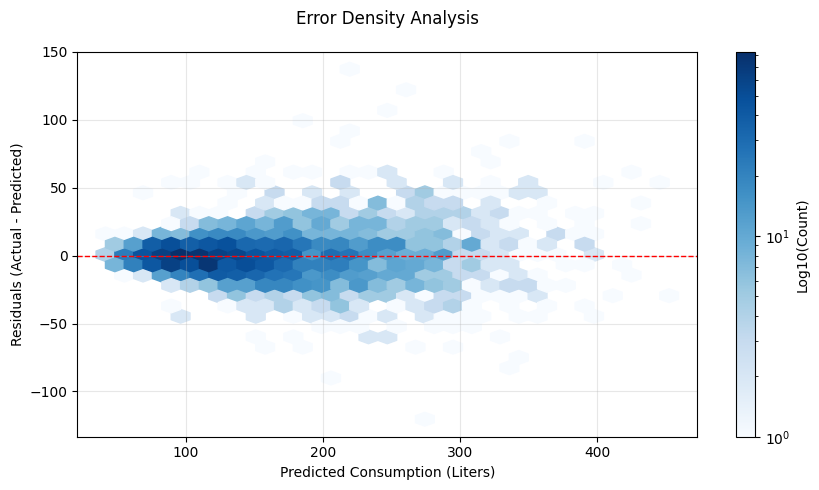

In [38]:
plt.figure(figsize=(10, 5))
plt.hexbin(y_pred, residuals, gridsize=30, cmap='Blues', bins='log')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.colorbar(label='Log10(Count)')
plt.xlabel('Predicted Consumption (Liters)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Error Density Analysis', pad=20)
plt.grid(alpha=0.3)

In [39]:
# Apply sample weighting
sample_weights = np.where(y_train > 300, 2.0, 1.0)
xgb.fit(X_train, y_train, sample_weight=sample_weights)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
bins = [0, 100, 200, 300, 500]
bin_results = pd.DataFrame({
    'Count': pd.cut(y_test_aligned, bins=bins).value_counts(),
    'Mean_Error': [residuals[(y_test_aligned >= l) & (y_test_aligned < r)].mean()
                  for l, r in zip(bins[:-1], bins[1:])]
})

In [41]:
monitoring_metrics = {
    'daily_rmse': [],
    'high_use_error': {
        'threshold': 300,
        'mean_error': None,
        'alert_count': 0
    }
}

In [42]:
def check_errors(predictions, actuals):
    residuals = actuals - predictions
    alerts = {}
    if (residuals.abs() > 50).mean() > 0.2:
        alerts['excessive_errors'] = True
    if (predictions > 300) & (residuals > 75).any():
        alerts['high_use_underprediction'] = True
    return alerts

In [45]:
import pickle
import pandas as pd

# Load your model (use the correct filename you saved)
with open('water_consumption_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Get feature names (works for both sklearn and xgboost)
try:
    # For XGBoost models
    required_features = model.get_booster().feature_names
except AttributeError:
    # For sklearn models
    required_features = model.feature_names_in_

print("Required features for prediction:")
print(required_features)

AttributeError: 'dict' object has no attribute 'feature_names_in_'

In [46]:
import pickle
import pandas as pd

# Load the saved model (replace with your actual filename)
try:
    with open('water_consumption_model.pkl', 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully!")
except FileNotFoundError:
    print("Error: Model file not found. Check the filename/path.")

Model loaded successfully!


In [47]:
# Get feature names (works for XGBoost, RandomForest, etc.)
try:
    if hasattr(model, 'feature_names_in_'):  # Scikit-learn models
        required_features = model.feature_names_in_
    elif hasattr(model, 'get_booster'):  # XGBoost
        required_features = model.get_booster().feature_names
    else:
        required_features = None
    print("Required features:", required_features)
except Exception as e:
    print(f"Error retrieving features: {e}")
    required_features = None

Required features: None


In [48]:
# Load test data (replace 'test_data.csv' with your file)
test_df = pd.read_csv('/content/test.csv')

# Check for missing features
if required_features is not None:
    missing_features = set(required_features) - set(test_df.columns)
    if missing_features:
        print(f"Warning: Missing features in test data: {missing_features}")
        # Option 1: Create missing features with defaults
        for feat in missing_features:
            test_df[feat] = 0  # Or use median/mean from training
        print("Missing features initialized to 0.")
    else:
        print("All required features present!")
else:
    print("Proceeding with all available features in test data.")

Proceeding with all available features in test data.


In [50]:


# Check for missing features
if required_features is not None:
    missing_features = set(required_features) - set(test_df.columns)
    if missing_features:
        print(f"Warning: Missing features in test data: {missing_features}")
        # Option 1: Create missing features with defaults
        for feat in missing_features:
            test_df[feat] = 0  # Or use median/mean from training
        print("Missing features initialized to 0.")
    else:
        print("All required features present!")
else:
    print("Proceeding with all available features in test data.")

Proceeding with all available features in test data.


In [51]:
# Select only the required features (if known)
if required_features is not None:
    X_test = test_df[list(required_features)]
else:
    X_test = test_df.select_dtypes(include=['number'])  # Fallback: use all numeric columns

# Predict
try:
    predictions = model.predict(X_test)
    test_df['Predicted_Water_Consumption'] = predictions.round(1)
    print("Predictions generated successfully!")
except Exception as e:
    print(f"Prediction failed: {e}")

Prediction failed: 'dict' object has no attribute 'predict'
